# Predictive coding in a single spiking neuron

In this example, we derive dynamical equations for predictive coding in a single spiking neuron [[1]](#refs). 

## Derivation

### Spiking mechanism as greedy minimization of squared-error loss function

The equations are based on two assumptions:

1. A time-dependent signal $x(t)$ is represented by a readout $y(t)$, which is a linear decoder by filtering the neuron's spike train $o(t)$ using the following equation:

    \begin{align}
        \dot{y}(t) = - y(t) + D o(t), 
    \end{align}
    
    where $D>0$ is a readout weight, and $o(t)=\sum_k \delta(t-t_k)$ is the sum of Dirac functions with spike times $\{t_k\}$.
2. The firing of the neuron is determined by minimizing a loss function defined by the squared error of $x(t)$ and $y(t)$:

    \begin{align}
        L(t) = \left(x(t) - y(t)\right)^2
    \end{align}

Each emitted spike minimizes $L(t)$ and consequently increases the readout by $D$. Thus,

\begin{align}
    L(t\,|\,\text{spike}) &< L(t\,|\,\text{no spike}) \\
    \Leftrightarrow \left(x(t) - (y(t)+D)\right)^2 &< \left(x(t) - y(t)\right)^2 \\
    \Leftrightarrow D^2-2Dx(t)+2Dy(t) &< 0 \\
    \Leftrightarrow D\left( x(t) - y(t) \right) &> \frac{D^2}{2} 
\end{align}

Finally, we interpret the left side as the membrane potential $V(t)$ of the neuron and the right side as the spiking threshold $\Theta$. Spike times $\{t_k\}$ are therefore defined as

\begin{align}
     t_k:\, V(t_k) > \Theta.
\end{align}

The membrane potential is proportional to the prediction error between the signal $x(t)$ and the readout $y(t)$.
 
### Differentiating membrane potential leads to integrate-and-fire dynamics

Differentiating $V(t)$ with respect to time leads to

\begin{align}
    \dot{V}(t) &= D\left(\dot{x}(t) + \dot{y}(t)\right) \\
            &= D\left(\dot{x}(t) - (- y(t) - Do(t))\right) \\
            &= D\dot{x}(t) + Dy(t) - D^2o(t) \\
            &= -D(x(t)-y(t)) + D(\dot{x}(t)+x(t)) - D^2o(t) \\
            &= -V(t) + Dc(t) - D^2 o(t),
\end{align}

which describe leaky integrate-and-fire dynamics with a excitatory feed-forward connection $D$ from the input signal $c(t)\equiv\dot{x}+x(t)$ and an inhibitory self-recurrent connection $D^2$.

## Numerical integration of the differential equation using Euler algorithm

In the following, we will simulate the neuron dynamics for a time interval of $t=$ {{T}} (a.u.) using a step size of $\Delta t =$ {{dt}}. The differential equations are numerically solved with the Euler algorithm:

\begin{align}
    x_{t} = x_{t-1} + \Delta t \cdot \dot{x}_{t-1}.
\end{align}

The input signal $x(t)$ is set to a constant value $a=$ {{a}} and the readout weight $D=$ {{D}}. Since we defined the spike train as a sum of Dirac functions $\int \delta(t) dt = 1$, we numerically approximate them as square pulses

\begin{align}
    \delta(t) \approx \begin{cases} \frac{1}{\Delta t} & \text{if } 0<t<\Delta t, \\ 0 & \text{otherwise.} \end{cases}
\end{align}

Thus, spike trains are defined in terms of unit pulses

\begin{align}
    \sum_k \delta(t-t_k) = \frac{1}{\Delta t}\delta\left[\frac{t-t_k}{\Delta t}\right] = \frac{1}{\Delta t}\delta[n-n_k],
\end{align}

where $n$ is the iteration step.

## Simulation code

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline

" Parameters/container definitions "
T        = 20                     # Total duration
dt       = 0.001                  # Integration time step        
time     = np.arange(0, T+dt, dt) # Time array        
V        = np.zeros(len(time))    # Membrane potential
a        = 1.0                    # Input amplitude
x        = a*np.ones(len(time))   # Input
hns      = int((T/dt)/2)          # Number of time steps for offset
x[0:hns] = 0.                     # Offset
y        = np.zeros(len(time))    # Decoder
o        = np.zeros(len(time))    # Spikes
st       = []                     # Spike times
rate     = np.zeros(len(time))    # Firing rate
D        = 0.05                   # Readout weights
Thr      = (D**2)/2               # Threshold
decay    = 1.0                    # Decay constant

" Voltage ODE "
def dV(i, spike):
    return - decay * V[i] + D*(x[i]+(x[i]-x[i-1])/dt) - D*D*spike/dt

" Decoder ODE "
def dy(i, spike):
    return - decay * y[i] + D*spike/dt

def dr(i, spike):
    return - rate[i] + spike/dt

def diff(a):
    return [a[i+1]-a[i] for i in range(len(a)-1)]

" Update step "
def step(i):
    if np.sum(o[i] > 0):
        st.append(t)
    " Potential (Euler) "
    V[i+1] = V[i] + dt * dV(i, o[i])   
    " Check spikes "    
    o[i+1] = (V[i+1] > Thr)
    " Decoder (Euler) "
    y[i+1] = y[i] + dt * dy(i, o[i+1])
    " Estimate firing rate (Euler) "
    rate[i+1] = rate[i] + dt * dr(i, o[i+1])
    
" Simulation "
for i,t in enumerate(time[:-1]):
    step(i)
print(np.sum(o)/(T/2))
print(1./np.mean(diff(st)))

22.0
21.9087635054


## Analyzing the readout for a constant input



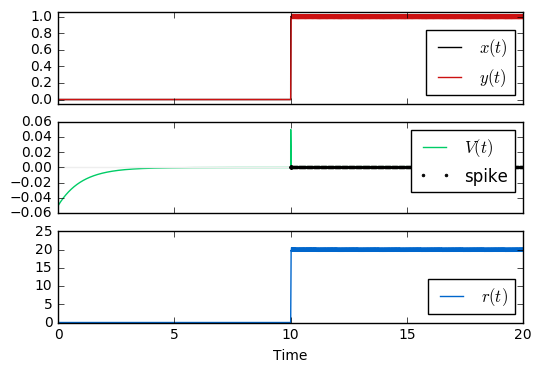

In [157]:
" Plotting signal, readout and membrane potential "
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(time, x, 'k-', label = '$x(t)$')
axarr[0].plot(time, y, color='#cc1111', label='$y(t)$')
axarr[0].set_ylim([-0.05, a+0.05])
axarr[0].legend(loc=4)

axarr[1].plot(time, V, color='#00cc66', label = '$V(t)$')
axarr[1].plot([0,T],[Thr,Thr], color='#eeeeee')
spikes, = axarr[1].plot(time[o[:]==1], Thr*o[o[:]==1], 'k.', markersize=4, label = 'spike')
axarr[1].legend(handler_map={spikes: HandlerLine2D(numpoints=1)})
axarr[1].legend()

axarr[2].plot(time, rate, color='#0066cc', label = '$r(t)$')
axarr[2].legend(loc=4)

plt.xlabel("Time")
plt.show()

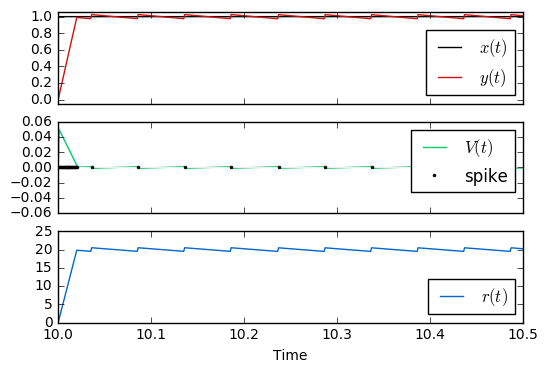

In [158]:
" Plotting signal, readout and membrane potential "
f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(time, x, 'k-', label = '$x(t)$')
axarr[0].plot(time, y, color='#cc1111', label='$y(t)$')
axarr[0].set_ylim([-0.05, a+0.05])
axarr[0].legend(loc=4)

axarr[1].plot(time, V, color='#00cc66', label = '$V(t)$')
axarr[1].plot([0,T],[Thr,Thr], color='#eeeeee')
spikes, = axarr[1].plot(time[o[:]==1], Thr*o[o[:]==1], 'k.', markersize=4, label = 'spike')
axarr[1].legend(handler_map={spikes: HandlerLine2D(numpoints=1)})

axarr[2].plot(time, rate, color='#0066cc', label = '$r(t)$')
axarr[2].legend(loc=4)

plt.xlim([10.000, 10.500])
plt.xlabel("Time")
plt.show()

## How does the readout weight affect accuracy and firing rate

Here, we vary the readout weight $D$ from $0.01$ to $1$ using increments of $0.01$. 

In [152]:
means = []
rates = []
Ds = []
" Goes through different values for D "
for trials in range(100):
    D = 0.01 * (trials+1)
    Ds.append(D)
    V        = np.zeros(len(time))    # Membrane potential
    y        = np.zeros(len(time))    # Decoder
    o        = np.zeros(len(time))    # Spikes
    rate     = np.zeros(len(time))    # Firing rate
    st = []
    for i,t in enumerate(time[:-1]):
        step(i)
    means.append(np.mean((x-y)**2))
    rates.append(1./np.mean(diff(st))) # based on ISI
    #print("D: %1.2f\tInverse Mean ISI:%1.9f (%u samples)" % (D, 1./np.mean(diff(st)), len(st)))
minD = Ds[np.argmin(means)]
print("Minimum error:", np.min(means), "at Gamma", minD)

Minimum error: 0.00229244690716 at Gamma 0.08


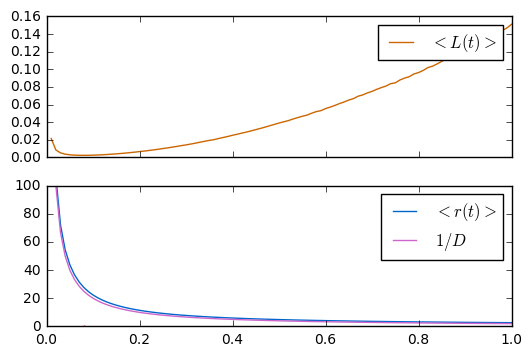

In [154]:
" Print/plot minimum error w.r.t. D "
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(Ds, means, color='#cc6600', label = '$<L(t)>$')
axarr[0].legend()
axarr[1].plot(Ds, rates, color='#0066cc', label = '$<r(t)>$')
axarr[1].plot([minD, minD], [0.0, 1.0], 'r--')
axarr[1].plot(Ds, 2./np.asarray(Ds), color='#cc66cc', label = '$1/D$')
axarr[1].set_ylim((0.0,100.0))
axarr[1].legend()
plt.show()

## References
<a id='refs'></a>

[1] Bourdoukan R, Barrett D, Deneve S, Machens CK. **Learning optimal spike-based representations.** In *Advances in neural information processing systems*, 2012 (pp. 2285-2293).